<a href="https://colab.research.google.com/github/aswit3/Start_Your_NLP_Career/blob/master/Word2Vec_train_own_embeddings.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
ls drive/My\ Drive/datasets/

dialogue-lines-of-the-simpsons.zip


In [0]:
!unzip drive/My\ Drive/datasets/dialogue-lines-of-the-simpsons.zip

Archive:  drive/My Drive/datasets/dialogue-lines-of-the-simpsons.zip
  inflating: simpsons_dataset.csv    


**Getting Started:**

**REFERENCE:**
https://www.kaggle.com/pierremegret/gensim-word2vec-tutorial

Setting up the environment:

python==3.6.3

Libraries used:

xlrd==1.1.0

spaCy==2.0.12

gensim==3.4.0

scikit-learn==0.19.1

seaborn==0.8

Dataset Link:

https://www.kaggle.com/pierremegret/dialogue-lines-of-the-simpsons

In [0]:
import re  # For preprocessing
import pandas as pd  # For data handling
from time import time  # To time our operations
from collections import defaultdict  # For word frequency

import spacy  # For preprocessing

In [0]:
df = pd.read_csv('simpsons_dataset.csv')
df.shape

(158314, 2)

In [0]:
df.head()

,raw_character_text,spoken_words
0,Miss Hoover,"No, actually, it was a little of both. Sometim..."
1,Lisa Simpson,Where's Mr. Bergstrom?
2,Miss Hoover,I don't know. Although I'd sure like to talk t...
3,Lisa Simpson,That life is worth living.
4,Edna Krabappel-Flanders,The polls will be open from now until the end ...


In [0]:
df.isnull().sum()

raw_character_text    17814
spoken_words          26459
dtype: int64

Removing the missing values:



In [0]:
df = df.dropna().reset_index(drop=True)
df.isnull().sum()

raw_character_text    0
spoken_words          0
dtype: int64

Cleaning:

We are lemmatizing and removing the stopwords and non-alphabetic characters for each line of dialogue.

In [0]:
nlp = spacy.load('en', disable=['ner', 'parser']) # disabling Named Entity Recognition for speed

def cleaning(doc):
    # Lemmatizes and removes stopwords
    # doc needs to be a spacy Doc object
    txt = [token.lemma_ for token in doc if not token.is_stop]
    # Word2Vec uses context words to learn the vector representation of a target word,
    # if a sentence is only one or two words long,
    # the benefit for the training is very small
    if len(txt) > 2:
        return ' '.join(txt)

Removes non-alphabetic characters:



In [0]:
brief_cleaning = (re.sub("[^A-Za-z']+", ' ', str(row)).lower() for row in df['spoken_words'])

Taking advantage of spaCy .pipe() attribute to speed-up the cleaning process:



In [0]:
t = time()

txt = [cleaning(doc) for doc in nlp.pipe(brief_cleaning, batch_size=5000, n_threads=-1)]

print('Time to clean up everything: {} mins'.format(round((time() - t) / 60, 2)))

Time to clean up everything: 1.81 mins


Put the results in a DataFrame to remove missing values and duplicates:



In [0]:
df_clean = pd.DataFrame({'clean': txt})
df_clean = df_clean.dropna().drop_duplicates()
df_clean.shape

(85960, 1)

Bigrams:

We are using Gensim Phrases package to automatically detect common phrases (bigrams) from a list of sentences. https://radimrehurek.com/gensim/models/phrases.html

The main reason we do this is to catch words like "mr_burns" or "bart_simpson" !

In [0]:
from gensim.models.phrases import Phrases, Phraser


As Phrases() takes a list of list of words as input:



In [0]:
sent = [row.split() for row in df_clean['clean']]

Creates the relevant phrases from the list of sentences:



In [0]:
phrases = Phrases(sent, min_count=30, progress_per=10000)

The goal of Phraser() is to cut down memory consumption of Phrases(), by discarding model state not strictly needed for the bigram detection task:

In [0]:
bigram = Phraser(phrases)

Transform the corpus based on the bigrams detected:



In [0]:
sentences = bigram[sent]

Most Frequent Words:

Mainly a sanity check of the effectiveness of the lemmatization, removal of stopwords, and addition of bigrams.

In [0]:
word_freq = defaultdict(int)
for sent in sentences:
    for i in sent:
        word_freq[i] += 1
len(word_freq)

29643

In [0]:
sorted(word_freq, key=word_freq.get, reverse=True)[:10]

['oh', 'like', 'know', 'get', 'hey', 'think', 'right', 'look', 'want', 'come']

# Training the model

**Gensim Word2Vec Implementation:**

We use Gensim implementation of word2vec: https://radimrehurek.com/gensim/models/word2vec.html

In [0]:
import multiprocessing

from gensim.models import Word2Vec

**Why I seperate the training of the model in 3 steps:**

I prefer to separate the training in 3 distinctive steps for clarity and monitoring.

**Word2Vec():**

In this first step, I set up the parameters of the model one-by-one. 
I do not supply the parameter sentences, and therefore leave the model uninitialized, purposefully.

**.build_vocab():**

Here it builds the vocabulary from a sequence of sentences and thus initialized the model. 
With the loggings, I can follow the progress and even more important, the effect of min_count and sample on the word corpus. I noticed that these two parameters, and in particular sample, have a great influence over the performance of a model. Displaying both allows for a more accurate and an easier management of their influence.

**.train():**

Finally, trains the model.
The loggings here are mainly useful for monitoring, making sure that no threads are executed instantaneously.

In [0]:
cores = multiprocessing.cpu_count() # Count the number of cores in a computer

The parameters:

**min_count** = int - Ignores all words with total absolute frequency lower than this - (2, 100)

**window** = int - The maximum distance between the current and predicted word within a sentence. E.g. window words on the left and window words on the left of our target - (2, 10)

**size** = int - Dimensionality of the feature vectors. - (50, 300)

**sample** = float - The threshold for configuring which higher-frequency words are randomly downsampled. Highly influencial. - (0, 1e-5)

**alpha** = float - The initial learning rate - (0.01, 0.05)

**min_alpha** = float - Learning rate will linearly drop to min_alpha as training progresses. To set it: alpha - (min_alpha * epochs) ~ 0.00

**negative** = int - If > 0, negative sampling will be used, the int for negative specifies how many "noise words" should be drown. If set to 0, no negative sampling is used. - (5, 20)

**workers** = int - Use these many worker threads to train the model (=faster training with multicore machines)

In [0]:
w2v_model = Word2Vec(min_count=20,
                     window=2,
                     size=300,
                     sample=6e-5, 
                     alpha=0.03, 
                     min_alpha=0.0007, 
                     negative=20,
                     workers=cores-1)

**Building the Vocabulary Table:**

Word2Vec requires us to build the vocabulary table (simply digesting all the words and filtering out the unique words, and doing some basic counts on them):

In [0]:
t = time()

w2v_model.build_vocab(sentences, progress_per=10000)

print('Time to build vocab: {} mins'.format(round((time() - t) / 60, 2)))

Time to build vocab: 0.04 mins


In [0]:
t = time()

w2v_model.train(sentences, total_examples=w2v_model.corpus_count, epochs=30, report_delay=1)

print('Time to train the model: {} mins'.format(round((time() - t) / 60, 2)))

Time to train the model: 1.67 mins


In [0]:
w2v_model.init_sims(replace=True)

In [0]:
import gensim
w2v_model.save('mymodel')
w2v_model = gensim.models.Word2Vec.load('mymodel')

/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:398: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


In [0]:
w2v_model.wv.most_similar(positive=["homer"])


/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


[('depressed', 0.7898377180099487),
 ('marge', 0.7710433006286621),
 ('snuggle', 0.7699807286262512),
 ('sweetheart', 0.7593809366226196),
 ('good_friend', 0.7583993673324585),
 ('terrific', 0.7515389919281006),
 ('feel_well', 0.7499527335166931),
 ('hammock', 0.7476987242698669),
 ('creepy', 0.7469173073768616),
 ('nervous', 0.7439180612564087)]

In [0]:
w2v_model.wv.most_similar(positive=["homer_simpson"])


/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


[('robert', 0.7724422216415405),
 ('select', 0.7724039554595947),
 ('congratulation', 0.7715653777122498),
 ('council', 0.7598058581352234),
 ('united_state', 0.756308913230896),
 ('pleased', 0.7521467208862305),
 ('recent', 0.7507676482200623),
 ('aboard', 0.7453206777572632),
 ('speaker', 0.7421400547027588),
 ('governor', 0.7343990206718445)]

In [0]:
w2v_model.wv.most_similar(positive=["marge"])


/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


[('sorry', 0.7768099308013916),
 ('surprised', 0.772522509098053),
 ('homer', 0.7710433006286621),
 ('sure', 0.7654531002044678),
 ('nervous', 0.7622281312942505),
 ('snuggle', 0.7587412595748901),
 ('glad', 0.7582883834838867),
 ('becky', 0.7580007314682007),
 ('hopeless', 0.7507026791572571),
 ('awww', 0.7506325244903564)]

In [0]:
w2v_model.wv.similarity('maggie', 'baby')

/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


0.7301624

What if we compared the friendship between Nelson, Bart, and Milhouse?



In [0]:
w2v_model.wv.doesnt_match(["nelson", "bart", "milhouse"])


/usr/local/lib/python3.6/dist-packages/gensim/models/keyedvectors.py:895: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  vectors = vstack(self.word_vec(word, use_norm=True) for word in used_words).astype(REAL)
/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


'nelson'

In [0]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
 
import seaborn as sns
sns.set_style("darkgrid")

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

In [0]:
def tsnescatterplot(model, word, list_names):
    """ Plot in seaborn the results from the t-SNE dimensionality reduction algorithm of the vectors of a query word,
    its list of most similar words, and a list of words.
    """
    arrays = np.empty((0, 300), dtype='f')
    word_labels = [word]
    color_list  = ['red']

    # adds the vector of the query word
    arrays = np.append(arrays, model.wv.__getitem__([word]), axis=0)
    
    # gets list of most similar words
    close_words = model.wv.most_similar([word])
    
    # adds the vector for each of the closest words to the array
    for wrd_score in close_words:
        wrd_vector = model.wv.__getitem__([wrd_score[0]])
        word_labels.append(wrd_score[0])
        color_list.append('blue')
        arrays = np.append(arrays, wrd_vector, axis=0)
    
    # adds the vector for each of the words from list_names to the array
    for wrd in list_names:
        wrd_vector = model.wv.__getitem__([wrd])
        word_labels.append(wrd)
        color_list.append('green')
        arrays = np.append(arrays, wrd_vector, axis=0)
        
    # Reduces the dimensionality from 300 to 50 dimensions with PCA
    reduc = PCA(n_components=10).fit_transform(arrays)
    
    # Finds t-SNE coordinates for 2 dimensions
    np.set_printoptions(suppress=True)
    
    Y = TSNE(n_components=2, random_state=0, perplexity=15).fit_transform(reduc)
    
    # Sets everything up to plot
    df = pd.DataFrame({'x': [x for x in Y[:, 0]],
                       'y': [y for y in Y[:, 1]],
                       'words': word_labels,
                       'color': color_list})
    
    fig, _ = plt.subplots()
    fig.set_size_inches(9, 9)
    
    # Basic plot
    p1 = sns.regplot(data=df,
                     x="x",
                     y="y",
                     fit_reg=False,
                     marker="o",
                     scatter_kws={'s': 40,
                                  'facecolors': df['color']
                                 }
                    )
    
    # Adds annotations one by one with a loop
    for line in range(0, df.shape[0]):
         p1.text(df["x"][line],
                 df['y'][line],
                 '  ' + df["words"][line].title(),
                 horizontalalignment='left',
                 verticalalignment='bottom', size='medium',
                 color=df['color'][line],
                 weight='normal'
                ).set_size(15)

    
    plt.xlim(Y[:, 0].min()-50, Y[:, 0].max()+50)
    plt.ylim(Y[:, 1].min()-50, Y[:, 1].max()+50)
            
    plt.title('t-SNE visualization for {}'.format(word.title()))
    

/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


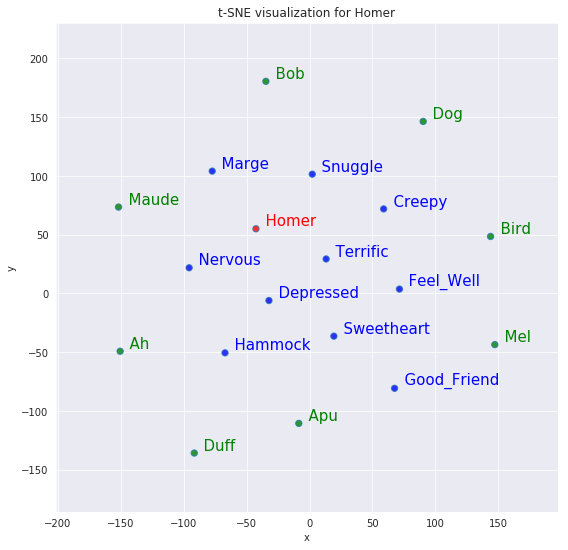

In [0]:
tsnescatterplot(w2v_model, 'homer', ['dog', 'bird', 'ah', 'maude', 'bob', 'mel', 'apu', 'duff'])
